In [1]:
# -*- coding: utf-8 -*-

## "Detection of Anomalies in Financial Transactions using Deep Autoencoder Networks"


The content of this "GPU Technology Conference (GTC) 2018, Silicon Valley" lab was jointly developed by Marco Schreyer and Timur Sattarov. Please don't hesitate to contact us in case of any questions via <a href="mailto:marco.schreyer@dfki.de">marco.schreyer@dfki.de</a> and <a href="mailto:sattarov.timur@pwc.com">sattarov.timur@pwc.com</a>.

## 1. Motivation

No need to ask :)

## 2. Environment Setup and Verification

### 2.1 Python Verification

Before we begin, let's verify that Python is working on your system. To do this, execute the cell block below by giving it focus (clicking on it with your mouse), and hitting Shift-Enter, or pressing the play button in the toolbar above. If all goes well, you should see some output returned below the grey cell.

In [2]:
print('The answer should be forty-two: {}'.format(str(40+2)))

The answer should be forty-two: 42


### 2.2 Python Libraries Import

As a next step let's import the libraries needed throughout the lab:

In [3]:
# importing utilities
import os
import sys
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
from IPython.display import Image, display

# importing pytorch libraries
import torch
from torch import nn
from torch import autograd
from torch.utils.data import DataLoader

# importing data science libraries
import pandas as pd
import random as rd
import numpy as np

### 2.3 CUDNN and GPU Verification

To determine if CDNN is available on the server let's execute the cell below to display information about the available CUDNN version:

In [4]:
# print CUDNN backend version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The CUDNN backend version: {}'.format(now, torch.backends.cudnn.version()))

[LOG 20180511-15:23:15] The CUDNN backend version: None


Also, let's display information about the potential GPUs running on the server:

In [5]:
!nvidia-smi

/bin/sh: nvidia-smi: command not found


If CUDNN and GPU's are available let's still specify if we want to use both:

In [6]:
USE_CUDA = False

### 2.4 Python and PyTorch Verification

Let's execute the cell below to display information about the Python and PyTorch version running on the server:

In [7]:
# print current Python version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The Python version: {}'.format(now, sys.version))

[LOG 20180511-15:23:16] The Python version: 2.7.14 (default, Feb  1 2018, 16:41:55) 
[GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.39.2)]


In [8]:
# print current PyTorch version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The PyTorch version: {}'.format(now, torch.__version__))

[LOG 20180511-15:23:16] The PyTorch version: 0.3.0.post4


### 2.5 Random Seed Initialization

Finally, let' set the seeds of random elements in the code e.g. the initialization of the network parameters to guarantee deterministic computation and results:

In [9]:
# init deterministic seed
seed_value = 1234 #4444 #3333 #2222 #1111 #1234
rd.seed(seed_value) # set random seed
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    torch.cuda.manual_seed(seed_value) # set pytorch seed GPU

## 3. Financial Fraud Detection Dataset

In this section, we will conduct a descriptive analysis of the labs financial dataset. Furthermore, we will apply some necessary pre-processing steps to train a deep neural network. The lab is based on a derivation of the **"Synthetic Financial Dataset For Fraud Detection"** by Lopez-Rojas [6] available via the Kaggle predictive modelling and analytics competitions platform that can be obtained using the following link: https://www.kaggle.com/ntnu-testimon/paysim1.

Let's start loading the dataset and investigate its structure and attributes:

In [10]:
# load the dataset into the notebook kernel
ori_dataset = pd.read_csv('./data/fraud_dataset_v2.csv')

In [11]:
# inspect the datasets dimensionalities
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] Transactional dataset of {} rows and {} columns loaded'.format(now, ori_dataset.shape[0], ori_dataset.shape[1]))

[LOG 20180511-15:23:18] Transactional dataset of 533009 rows and 10 columns loaded


### 3.1 Initial Data and Attribute Assessment

We augmented the dataset and renamed the attributes to appear more similar to a real-world dataset that one usually observes in SAP-ERP systems as part of SAP's Finance and Cost controlling (FICO) module. 

The dataset contains a subset of in total 7 categorical and 2 numerical attributes available in the FICO BKPF (containing the posted journal entry headers) and BSEG (containing the posted journal entry segments) tables. Please, find below a list of the individual attributes as well as a brief description of their respective semantics:

>- `BELNR`: the accounting document number,
>- `BUKRS`: the company code,
>- `BSCHL`: the posting key,
>- `HKONT`: the posted general ledger account,
>- `PRCTR`: the posted profit center,
>- `WAERS`: the currency key,
>- `KTOSL`: the general ledger account key,
>- `DMBTR`: the amount in local currency,
>- `WRBTR`: the amount in document currency.

Let's also have a closer look into the top 10 rows of the dataset:

In [12]:
# inspect top rows of dataset
ori_dataset.head(10) 

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
0,288203,C3,C31,C9,C92,A3,B1,280979.60,0.00,regular
1,324441,C1,C18,C7,C76,A1,B2,129856.53,243343.00,regular
2,133537,C1,C19,C2,C20,A1,B3,957463.97,3183838.41,regular
3,331521,C4,C48,C9,C95,A2,B1,2681709.51,28778.00,regular
4,375333,C5,C58,C1,C19,A3,B1,910514.49,346.00,regular
5,327203,C1,C15,C6,C68,A1,B2,357627.56,704520.00,regular
6,292545,C4,C47,C2,C28,A2,B3,955576.84,128328.00,regular
7,335839,C1,C19,C1,C17,A1,B1,41769.26,0.00,regular
8,369064,C4,C40,C9,C97,A2,B1,44309.79,0.00,regular
9,138724,C6,C69,C1,C12,A2,B1,466720.45,43843.00,regular


You may also have noticed the attribute `label` in the data. We will use this field throughout the lab to evaluate the quality of our trained models. The field describes the true nature of each individual transaction of either being a **regular** transaction (denoted by `regular`) or an **anomaly** (denoted by `global` and `local`). Let's have closer look into the distribution of the regular vs. anomalous transactions in the dataset:

In [13]:
# number of anomalies vs. regular transactions
ori_dataset.label.value_counts()

regular    532909
global         70
local          30
Name: label, dtype: int64

Ok, the statistic reveals that, similar to real world scenarios, we are facing a highly "unbalanced" dataset. Overall, the dataset contains only a small fraction of **100 (0.018%)** anomalous transactions. While the 100 anomalous entries encompass **70 (0.013%)** "global" anomalies and **30 (0.005%)** "local" anomalies as introduced in section 1.2.

In [14]:
# remove the "ground-truth" label information for the following steps of the lab
label = ori_dataset.pop('label')

### 3.2 Pre-Processing of Categorical Transaction Attributes

From the initial data assessment above we can observe that the majority of attributes recorded in AIS- and ERP-systems correspond to categorical (discrete) attribute values, e.g. the posting date, the general-ledger account, the posting type, the currency. Let's have a more detailed look into the distribution of two dataset attributes, namely (1) the posting key `BSCHL` as well as (2) the general ledger account `HKONT`:

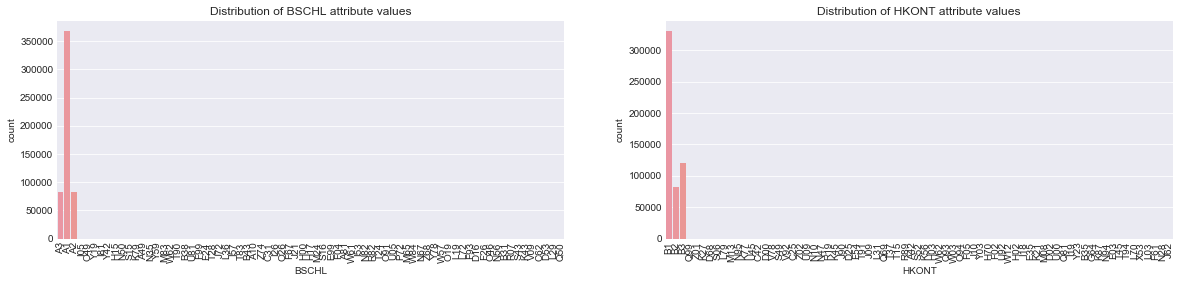

In [15]:
# prepare to plot posting key and general ledger account side by side
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)

# plot the distribution of the posting key attribute
g = sns.countplot(x=ori_dataset['BSCHL'], ax=ax[0])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Distribution of BSCHL attribute values')

# plot the distribution of the general ledger account attribute
g = sns.countplot(x=ori_dataset['HKONT'], ax=ax[1])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Distribution of HKONT attribute values')

Unfortunately, neural networks are in general not designed to be trained directly on categorical data and require the attributes to be trained on to be numeric. One simple way to meet this requirement is by applying a technique referred to as **"one-hot" encoding**. Using this encoding technique, we will derive a numerical representation of each of the categorical attribute values. One-hot encoding creates new binary columns for each categorical attribute value present in the original data. 

Let's work through a brief example: The **categorical attribute “Receiver”** below contains the names "John", "Timur" and "Marco". We "one-hot" encode the names by creating a separate binary column for each possible name value observable in the "Receiver" column. Now, we encode for each transaction that contains the value "John" in the "Receiver" column this observation with 1.0 in the newly created "John" column and 0.0 in all other created name columns.

<img align="middle" style="max-width: 430px; height: auto" src="images/encoding.png">

Using this technique will "one-hot" encode the 6 categorical attributes in the original transactional dataset. This can be achieved using the `get_dummies()` function available in the Pandas data science library:  

In [16]:
# select categorical attributes to be "one-hot" encoded
categorical_attr_names = ['KTOSL', 'PRCTR', 'BSCHL', 'HKONT', 'BUKRS', 'WAERS']

# encode categorical attributes into a binary one-hot encoded representation 
ori_dataset_categ_transformed = pd.get_dummies(ori_dataset[categorical_attr_names])

Finally, let's inspect the encoding of 10 sample transactions to see if we have been successfull.

In [17]:
# inspect encoded sample transactions
ori_dataset_categ_transformed.head(10)

,KTOSL_A19,KTOSL_B06,KTOSL_B12,KTOSL_B83,KTOSL_C1,KTOSL_C2,KTOSL_C3,KTOSL_C39,KTOSL_C4,KTOSL_C5,...,WAERS_U72,WAERS_U94,WAERS_V89,WAERS_W25,WAERS_W59,WAERS_X26,WAERS_Y59,WAERS_Z06,WAERS_Z37,WAERS_Z54
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3.3 Merge Categorical and Numerical Transaction Attributes

Finally, we merge both pre-processed numerical and categorical attributes into a single dataset that we will use for training our deep autoencoder neural network (explained an implemented in the following section 4.):

In [18]:
# merge categorical and numeric subsets
ori_subset_transformed = ori_dataset_categ_transformed

Now, let's again have a look at the dimensionality of the dataset after we applied the distinct pre-processing steps to the attributes:

In [19]:
# inspect final dimensions of pre-processed transactional data
ori_subset_transformed.shape

(533009, 616)

Ok, upon completion of all the pre-processing steps (incl. the exercises) we should end up with an encoded dataset consisting of a total number of 533,009 records (rows) and **616 encoded attributes** (columns). Let's keep the number number of columns in mind since it will define the dimensionality of the input- and output-layer of our deep autoencoder network which we will now implement in the following section.

## 4. Adversarial Autoencoder Neural Network

### 4.1 Autoencoder Neural Network Architecture

Needs to be done.

### 4.2 Adversarial Autoencoder Neural Network Implementation

Implementation of the encoder network:

In [20]:
# implementation of the encoder network
class encoder(nn.Module):

    def __init__(self):

        super(encoder, self).__init__()
        
        # init dropout layer with probability p
        self.dropout = nn.Dropout(p=0.0, inplace=True)

        # specify layer 1 - in 616, out 512
        self.encoder_L1 = nn.Linear(in_features=616, out_features=512, bias=True) # add linearity 
        nn.init.xavier_uniform(self.encoder_L1.weight) # init weights according to [9]
        self.encoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify layer 2 - in 512, out 3
        self.encoder_L2 = nn.Linear(512, 3, bias=True)
        nn.init.xavier_uniform(self.encoder_L2.weight)
        self.encoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
    def forward(self, x):

        # define forward pass through the network
        x = self.encoder_R1(self.dropout(self.encoder_L1(x)))
        x = self.encoder_R2(self.encoder_L2(x)) # don't apply dropout to the AE bottleneck

        return x

Init and push to CUDNN / GPU if avalable:

In [21]:
# init training network classes / architectures
encoder_train = encoder()

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    encoder_train = encoder().cuda()

Validate correct initialization:

In [22]:
# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] encoder architecture:\n\n{}\n'.format(now, encoder_train))

[LOG 20180511-15:24:45] encoder architecture:

encoder(
  (dropout): Dropout(p=0.0, inplace)
  (encoder_L1): Linear(in_features=616, out_features=512)
  (encoder_R1): LeakyReLU(0.4, inplace)
  (encoder_L2): Linear(in_features=512, out_features=3)
  (encoder_R2): LeakyReLU(0.4, inplace)
)



Implementation of the decoder network:

In [23]:
# implementation of the decoder network
class decoder(nn.Module):

    def __init__(self):

        super(decoder, self).__init__()
        
        # init dropout layer with probability p
        self.dropout = nn.Dropout(p=0.0, inplace=True)

        # specify layer 1 - in 3, out 512
        self.decoder_L1 = nn.Linear(in_features=3, out_features=512, bias=True) # add linearity 
        nn.init.xavier_uniform(self.decoder_L1.weight)  # init weights according to [9]
        self.decoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify layer 2 - in 512, out 616
        self.decoder_L2 = nn.Linear(512, 616, bias=True)
        nn.init.xavier_uniform(self.decoder_L2.weight)
        self.decoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

    def forward(self, x):

        # define forward pass through the network
        x = self.decoder_R1(self.dropout(self.decoder_L1(x)))
        x = self.decoder_R2(self.decoder_L2(x)) # don't apply dropout to the AE output
        
        return x

Init and push to CUDNN / GPU if avalable:

In [24]:
# init training network classes / architectures
decoder_train = decoder()

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    decoder_train = decoder().cuda()

Validate correct initialization:

In [25]:
# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] decoder architecture:\n\n{}\n'.format(now, decoder_train))

[LOG 20180511-15:26:16] decoder architecture:

decoder(
  (dropout): Dropout(p=0.0, inplace)
  (decoder_L1): Linear(in_features=3, out_features=512)
  (decoder_R1): LeakyReLU(0.4, inplace)
  (decoder_L2): Linear(in_features=512, out_features=616)
  (decoder_R2): LeakyReLU(0.4, inplace)
)



Implementation of the discriminator network:

In [26]:
# implementation of the discriminator network
class discriminator(nn.Module):

    def __init__(self):

        super(discriminator, self).__init__()

        # init dropout layer with probability p
        self.dropout = nn.Dropout(p=0.0, inplace=True)

        # specify layer 1 - in 3, out 512
        self.discriminator_L1 = nn.Linear(3, 512)
        nn.init.xavier_uniform(self.discriminator_L1.weight)
        self.relu1 = nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
        # specify layer 2 - in 512, out 1
        self.discriminator_L2 = nn.Linear(512, 1)
        nn.init.xavier_uniform(self.discriminator_L2.weight)
        self.sigmo1 = nn.Sigmoid()


    def forward(self, x):

        x = self.relu1(self.dropout(self.discriminator_L1(x)))
        discrimination = self.sigmo1(self.discriminator_L2(x))

        return discrimination

Init and push to CUDNN / GPU if avalable:

In [27]:
# init training network classes / architectures
discriminator_train = discriminator()

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    discriminator_train = discriminator().cuda()

Validate correct initialization:

In [28]:
# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] discriminator architecture:\n\n{}\n'.format(now, discriminator_train))

[LOG 20180511-15:28:20] discriminator architecture:

discriminator(
  (dropout): Dropout(p=0.0, inplace)
  (discriminator_L1): Linear(in_features=3, out_features=512)
  (relu1): LeakyReLU(0.4, inplace)
  (discriminator_L2): Linear(in_features=512, out_features=1)
  (sigmo1): Sigmoid()
)



### 4.3 Autoencoder Neural Network Training

Define the learning rate of the training:

In [29]:
learning_rate = 1e-3

Define autoencoder reconstruction loss function:

In [30]:
# define the optimization criterion / loss function
rec_loss = nn.BCELoss(size_average=True)

Define autoencoder (encoder and decoder net) parameter optimizer:

In [31]:
# define learning rate and optimization strategy
encoder_optimizer = torch.optim.Adam(encoder_train.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.Adam(decoder_train.parameters(), lr=learning_rate)

Define regularization and generation loss function:

In [32]:
# define the regularization loss / generation loss function
reg_loss = nn.BCELoss(size_average=True)
gen_loss = nn.BCELoss(size_average=True)

Define generator net (equals encoder net) optimizer:

In [33]:
# define optimization criterion and optimizer - generative net
encoder_generator_optimizer = torch.optim.Adam(encoder_train.parameters(), lr=learning_rate)

Define discriminator net optimizer:

In [34]:
discriminator_optimizer = torch.optim.Adam(discriminator_train.parameters(), lr=learning_rate)

## 5. Training the Adversarial Autoencoder Neural Network (AENN) Model

In this section, we will train our deep autoencoder neural network (as implemented in section 4. of the lab) using the encoded transactional data (created in section 3. of the lab). More specifically, we will have a detailed look into the distinct training steps as well as how to monitor the training progress.

### 5.1 Preparing the Network Training

We have pre-processed the dataset, implemented the AENN and defined the reconstruction error. Let's now start to train a corresponding model for **5 epochs** and a **mini-batch size of 128** journal entries per batch. This implies that the whole dataset will be fed to the AENN 5 times in chunks of 128 journal entries yielding to 4,165 mini-batches (533,009 journal entries / 128 journal entries per mini-batch) per epoch.

In [35]:
# specify training parameters
num_epochs = 10
mini_batch_size = 128

During the training phase, we will fetch the individual mini-batches of the entire population of journal entries. To achieve this, we will use PyTorch's `DataLoader` that provides single- or multi-process iterators over a given dataset to load one mini-batch at a time. By enabling `shuffle=True` the data will be reshuffled at every epoch prior to feeding it to the network. 

In [36]:
# convert pre-processed data to pytorch tensor
torch_dataset = torch.from_numpy(ori_subset_transformed.values).float()

# convert to pytorch tensor - none cuda enabled
dataloader = DataLoader(torch_dataset, batch_size=mini_batch_size, shuffle=True, num_workers=0)
# note: we set num_workers to zero to retrieve deterministic results

# determine if CUDA is available at compute node
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    dataloader = DataLoader(torch_dataset.cuda(), batch_size=mini_batch_size, shuffle=True)

### 5.2 Running the Network Training

In [ ]:
# init collection of training losses
reconstruction_losses = []
discrimination_losses_fake = []
discrimination_losses_real = []
generation_losses = []

# convert encoded transactional data to torch Variable
data = autograd.Variable(torch_dataset)

# train adversarial autoencoder model
for epoch in range(num_epochs):

    # init mini batch counter
    mini_batch_count = 0

    if (torch.backends.cudnn.version() != None) and (use_cuda == True):

        # set all networks / models in GPU mode
        encoder_train.cuda()
        decoder_train.cuda()
        discriminator_train.cuda()

    # set networks in training mode (apply dropout when needed)
    encoder_train.train()
    decoder_train.train()
    discriminator_train.train()
    
    # start timer
    start_time = datetime.now()

    # iterate over epoch mini batches
    for mini_batch_data in dataloader:

        # increase mini batch counter
        mini_batch_count += 1

        # convert mini batch to torch variable
        mini_batch_torch = autograd.Variable(mini_batch_data)

        # reset the networks gradients
        encoder_train.zero_grad()
        decoder_train.zero_grad()
        discriminator_train.zero_grad()

        # =================== reconstruction phase =====================
        
        # =================== encoder and decoder training
        
        # run autoencoder encoding - decoding
        z_sample = encoder_train(mini_batch_torch)
        mini_batch_reconstruction = decoder_train(z_sample)

        # determine reconstruction loss
        reconstruction_loss = rec_loss(input=mini_batch_reconstruction, target=mini_batch_torch)

        # run backward pass - determine gradients
        reconstruction_loss.backward()
        
        # collect reconstruction loss
        reconstruction_losses.extend([reconstruction_loss.data[0]])

        # update network parameter - decoder and encoder
        decoder_optimizer.step()
        encoder_optimizer.step()

        if mini_batch_count % 10 == 0:

            print('------------------------------------------')
            # print mini batch reconstuction results
            now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
            print('[PT LOG TRAIN {}] epoch: [{:04}/{:04}], batch: {:04}, reconstruction loss: {:.10f}'.format(now, epoch + 1, num_epochs, mini_batch_count, reconstruction_loss.data[0]))
            # print('[PT LOG TRAIN {}] epoch: [{:04}/{:04}], dec L1 mean: {:.8f}, dec L2 mean: {:.8f}, dec L3 mean: {:.8f}'.format(now, epoch + 1, num_epochs, torch.mean(decoder.decoder_L1.weight).data[0], torch.mean(decoder.decoder_L2.weight).data[0], torch.mean(decoder.decoder_L3.weight).data[0]))
            print('-----------------')

        # =================== regularization phase =====================

        # =================== discriminator training

        # set discriminator in evaluation mode
        discriminator_train.eval()

        # set z dimension to be sampled from
        z_dim = 3
        
        # sample randomly from gaussian distribution -> real gaussian sample
        z_real_gauss = autograd.Variable(torch.randn(torch_dataset.size()[0], z_dim) - 0.0)

        if (torch.backends.cudnn.version() != None) and (use_cuda == True):

            z_real_gauss = z_real_gauss.cuda()

        # determine mini batch sample generated by the encoder -> fake gaussian sample
        z_fake_gauss = encoder_train(mini_batch_torch)

        # determine discriminator classification of both samples
        d_real_gauss = discriminator_train(z_real_gauss) # real sampled gaussian 
        d_fake_gauss = discriminator_train(z_fake_gauss) # fake created gaussian

        # determine discriminator classification target variables
        d_real_gauss_target = autograd.Variable(torch.ones(d_real_gauss.data.size())) # real -> 1
        d_fake_gauss_target = autograd.Variable(torch.zeros(d_fake_gauss.data.size())) # fake -> 0

        if (torch.backends.cudnn.version() != None) and (use_cuda == True):

            d_real_gauss_target = d_real_gauss_target.cuda()
            d_fake_gauss_target = d_fake_gauss_target.cuda()

        # determine individual discrimination losses
        discrimination_loss_real = reg_loss(target=d_real_gauss_target, input=d_real_gauss) # real loss
        discrimination_loss_fake = reg_loss(target=d_fake_gauss_target, input=d_fake_gauss) # fake loss

        # collection discrimination losses
        discrimination_losses_real.extend([discrimination_loss_real.data[0]])
        discrimination_losses_fake.extend([discrimination_loss_fake.data[0]])
        
        # add real loss and fake loss
        discrimination_loss = discrimination_loss_fake + discrimination_loss_real

        # run backward through the discriminator network
        discrimination_loss.backward()

        # update network the discriminator network parameters
        discriminator_optimizer.step()

        # reset the networks gradients
        encoder_train.zero_grad()
        decoder_train.zero_grad()
        discriminator_train.zero_grad()

        if mini_batch_count % 10 == 0:

            # print mini batch reconstuction results
            now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
            print('[PT LOG TRAIN {}] epoch: [{:04}/{:04}], batch: {:04}, discrimination loss: {:.10f} [r_{:.10f}/f_{:.10f}]'.format(now, epoch + 1, num_epochs, mini_batch_count, discrimination_loss.data[0], discrimination_loss_real.data[0], discrimination_loss_fake.data[0]))
            print('-----------------')

        # =================== generator training

        # set encoder / generator in training mode
        encoder_train.train()
        
        # reset the encoder / generator networks gradients
        encoder_train.zero_grad()

        # determine fake gaussian sample generated by the encoder / generator
        z_fake_gauss = encoder_train(mini_batch_torch)

        # determine discriminator classification of fake gaussian sample
        d_fake_gauss = discriminator_train(z_fake_gauss)

        # determine discriminator classification target variables
        d_fake_gauss_target = autograd.Variable(torch.ones(d_fake_gauss.data.size())) # fake -> 1

        if (torch.backends.cudnn.version() != None) and (use_cuda == True):

            d_fake_gauss_target = d_fake_gauss_target.cuda()

        # determine discrimination loss of fake gaussian sample
        generation_loss = gen_loss(target=d_fake_gauss_target, input=d_fake_gauss)
        
        # collect generation losses
        generation_losses.extend([generation_loss.data[0]])

        # run backward pass - determine gradients
        generation_loss.backward()

        # update network paramaters - encoder / generatorc
        encoder_generator_optimizer.step()

        # reset the networks gradients
        encoder_train.zero_grad()
        decoder_train.zero_grad()
        discriminator_train.zero_grad()

        if mini_batch_count % 10 == 0:

            # print mini batch reconstuction results
            now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
            print('[PT LOG TRAIN {}] epoch: [{:04}/{:04}], batch: {:04}, generator loss: {:.10f}'.format(now, epoch + 1, num_epochs, mini_batch_count, generation_loss.data[0]))
            #print('[PT LOG TRAIN {}] epoch: [{:04}/{:04}], enc L1 mean: {:.8f}, enc L2 mean: {:.8f}, enc L3 mean: {:.8f}'.format(now, epoch + 1, num_epochs, torch.mean(encoder.encoder_L1.weight).data[0], torch.mean(encoder.encoder_L2.weight).data[0], torch.mean(encoder.encoder_L3.weight).data[0]))
            print('------------------------------------------')

    # =================== save model snapshots to disk ============================
    
    # save trained encoder model file to disk
    now = datetime.utcnow().strftime("%Y%m%d-%H_%M_%S")
    encoder_model_name = "{}_ep_{}_encoder_model.pth".format(now, (epoch+1))
    torch.save(encoder_train.state_dict(), os.path.join("./models", encoder_model_name))

    # save trained decoder model file to disk
    decoder_model_name = "{}_ep_{}_decoder_model.pth".format(now, (epoch+1))
    torch.save(decoder_train.state_dict(), os.path.join("./models", decoder_model_name))
    
    # save trained discriminator model file to disk
    decoder_model_name = "{}_ep_{}_discriminator_model.pth".format(now, (epoch+1))
    torch.save(discriminator_train.state_dict(), os.path.join("./models", decoder_model_name))

------------------------------------------
[PT LOG TRAIN 20180511-15:31:01] epoch: [0001/0010], batch: 0010, reconstruction loss: 0.2496831268
-----------------
[PT LOG TRAIN 20180511-15:31:06] epoch: [0001/0010], batch: 0010, discrimination loss: 0.9454929829 [r_0.5459252000/f_0.3995678127]
-----------------
[PT LOG TRAIN 20180511-15:31:06] epoch: [0001/0010], batch: 0010, generator loss: 1.1418374777
------------------------------------------
------------------------------------------
[PT LOG TRAIN 20180511-15:31:50] epoch: [0001/0010], batch: 0020, reconstruction loss: 0.1594869494
-----------------
[PT LOG TRAIN 20180511-15:31:55] epoch: [0001/0010], batch: 0020, discrimination loss: 0.7628086805 [r_0.4380775392/f_0.3247311413]
-----------------
[PT LOG TRAIN 20180511-15:31:55] epoch: [0001/0010], batch: 0020, generator loss: 1.3210605383
------------------------------------------
------------------------------------------
[PT LOG TRAIN 20180511-15:32:39] epoch: [0001/0010], batch:

Let's now evaluate if the loss function is indeed going down with progressing training of the model. Therefore, let's visualize the magnitudes of the losses obtained per training epoch:

In [ ]:
# plot the training progress
plt.plot(range(0, len(losses)), losses)
plt.xlabel('[training epoch]')
plt.xlim([0, len(losses)])
plt.ylabel('[reconstruction-error]')
#plt.ylim([0.0, 1.0])
plt.title('AENN training performance')

How does the reconstruction loss change as we progress in training our model? After 5 epochs, we can observe that our reconstruction loss already went down significantly and starts to converge nicely. This indicates that our network did a pretty good job in learning the structure and attributes of the journal entries.

But, from the plot we also observe that the model could probably be trained a couple more epochs as the trend of the reconstruction error still decreases for the last few epochs. In order to save time, we will continue the lab using a pre-trained model already trained by 20 epochs.

### Exercises:

Before we continue with the next notebook section it's time for some exercises:

>1. Set the `USE_CUDA` flag to `False` and re-start the training procedure. What impact do you observe in terms of training time needed for training a single epoch? Please, note that after altering the `USE_CUDA` flag you need to execute all successive cells starting from section 4.2. [5-10 min]
>2. Set the `dropout` probability to `0.8` (80%) and re-start the training procedure. What impact do you observe in terms of training performance / reconstruction loss? Please, note that after altering the `dropout` probability you need to execute all successive cells starting from section 4.2. [5-10 min]

## 6. Evaluating the Autoencoder Neural Network (AENN) Model

Now that we know how to train our autoencoder model, we will explore how we can use it to detect anomalies within the entire population of journal entries. Initially, we will start by loading a pre-trained model of 20 epochs and assess its reconstruction capability on the entire dataset. 

The pre-trained model is stored in the same directory as the lab notebook and can be loaded by executing the cell below: 

In [ ]:
# restore pretrained model checkpoint
encoder_model_name = "20180322-12_26_40_ep_20_encoder_model.pth"
decoder_model_name = "20180322-12_26_40_ep_20_decoder_model.pth"

# init training network classes / architectures
encoder_eval = encoder()
decoder_eval = decoder()

# load trained models
encoder_eval.load_state_dict(torch.load(os.path.join("models", encoder_model_name)))
decoder_eval.load_state_dict(torch.load(os.path.join("models", decoder_model_name)))

### 6.1 Assessment of the Pre-Trained Model

Once obtained, let's use the model to reconstruct the entire dataset:

In [ ]:
# convert encoded transactional data to torch Variable
data = autograd.Variable(torch_dataset)

# set networks in evaluation mode (don't apply dropout)
encoder_eval.eval()
decoder_eval.eval()

# reconstruct encoded transactional data
reconstruction = decoder_eval(encoder_eval(data))

Now, let's assess its quality by calculating the reconstruction error over the entire dataset:

In [ ]:
# determine reconstruction loss - all transactions
reconstruction_loss_all = loss_function(reconstruction, data)

# print reconstruction loss - all transactions
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] collected reconstruction loss of: {:06}/{:06} transactions'.format(now, reconstruction.size()[0], reconstruction.size()[0]))
print('[LOG {}] reconstruction loss: {:.10f}'.format(now, reconstruction_loss_all.data[0]))

Ok, nice. Comparing the overall reconstruction loss of the pre-trained model trained for **20 epochs** to the one we initially trained for **5 epochs** reveals, that the pre-trained model results in a significantly lower reconstruction error. We can therefore conclude that the pre-trained model outperforms our initial model in capturing the inherent characteristics of the journal entries.

### 6.2 Assessment of the Individual Transactions

Ok, now that we are convinced that the pre-trained model is of decent quality let's assess the individual journal entries of the dataset. To achieve this, we collect the reconstruction errors of each individual journal entry by executing the cell below:

In [ ]:
# init binary cross entropy errors
reconstruction_loss_transaction = np.zeros(reconstruction.size()[0])

# iterate over all detailed reconstructions
for i in range(0, reconstruction.size()[0]):

    # determine reconstruction loss - individual transactions
    reconstruction_loss_transaction[i] = loss_function(reconstruction[i], data[i]).data[0]

    if(i % 100000 == 0):

        ### print conversion summary
        now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
        print('[LOG {}] collected individual reconstruction loss of: {:06}/{:06} transactions'.format(now, i, reconstruction.size()[0]))
        

Once we have collected individual reconstruction errors let's visualize them accordingly:

In [ ]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# assign unique id to transactions
plot_data = np.column_stack((np.arange(len(reconstruction_loss_transaction)), reconstruction_loss_transaction))

# obtain regular transactions as well as global and local anomalies
regular_data = plot_data[label == 'regular']
global_outliers = plot_data[label == 'global']
local_outliers = plot_data[label == 'local']

# plot reconstruction error scatter plot
ax.scatter(regular_data[:, 0], regular_data[:, 1], c='C0', alpha=0.4, marker="o", label='regular') # plot regular transactions
ax.scatter(global_outliers[:, 0], global_outliers[:, 1], c='C1', marker="^", label='global') # plot global outliers
ax.scatter(local_outliers[:, 0], local_outliers[:, 1], c='C2', marker="^", label='local') # plot local outliers

# add plot legend of transaction classes
ax.legend(loc='best')

The visualization reveals that the pre-trained model is able to reconstruct the majority of regular journal entries, while failing to do so, for the anomalous ones. As a result, the model reconstruction error can be used to distinguish both "global" anomalies (orange) and "local" anomalies (green) from the regular journal entries (blue).

To further investigate our observation and confirm the initial assumption, let's have a closer look into the journal entries exhibiting a "high" binary cross-entropy reconstruction error >= 0.1. We assume that these journal entries correspond to the "global" anomalies of the original dataset:

In [ ]:
# append labels to original dataset
ori_dataset['label'] = label

# inspect transactions exhibiting a reconstruction error >= 0.2
ori_dataset[reconstruction_loss_transaction >= 0.2]

Let's now also have a closer look into the journal entries exhibiting a "medium" binary cross-entropy reconstruction error >= 0.02 and < 0.1. We assume that these journal entries mostly correspond to the "local" anomalies of the original dataset:

In [ ]:
# inspect transactions exhibiting a reconstruction error < 0.1 and >= 0.05
ori_dataset[(reconstruction_loss_transaction >= 0.05) & (reconstruction_loss_transaction < 0.1)]

## 7. Optional Exercises

Please read ahead and only come back to these optional exercises if time permits.

**1. Train the autoencoder model from scratch** [15 mins]

First, change the number of training epochs `num_epochs` to **30** in the corresponding cell of section 5.1. Second, you might also want to try different learning rates other than the initial learning rate of **0.001** in the corresponding cell of section 4.3. Third, comment out the two lines in the first cell of section 6. where the pre-trained model is defined (under "restore pre-trained model checkpoint") as well as two lines where it is loaded (under "load trained models"). 

Please, note that after altering the number of training epochs in section 5.1 and/or the learning rate in section 4.3 you need to execute all successive cells starting from section 5.1 or 4.3.

**2. What would happen if we remove a few fully-connected layers?** [15 mins]

We designed a specific model for the lab because experiments show that the structure provided result in a good detection accuracy. Let's see how the reconstruction performance change if we would **remove several of the hidden layers**. First, adjust the encoder and decoder model definitions in section 4.2 accordingly (you may want to use the code snippets shown below). Then, follow all the instructions for training from scratch.

Please, note that after altering the encoder and / or decoder network architecture in section 4.2 you need to execute all successive cells starting from section 4.2.

In [ ]:
# implementation of the shallow encoder network 
# containing only a single layer
class encoder(nn.Module):

    def __init__(self):

        super(encoder, self).__init__()

        # specify layer 1 - in 618, out 3
        self.encoder_L1 = nn.Linear(in_features=618, out_features=3, bias=True) # add linearity 
        nn.init.xavier_uniform(self.encoder_L1.weight) # init weights according to [9]
        self.encoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]
        
    def forward(self, x):

        # define forward pass through the network
        x = self.encoder_R1(self.encoder_L1(x)) # don't apply dropout to the AE bottleneck

        return x

In [ ]:
# implementation of the shallow decoder network 
# containing only a single layer
class decoder(nn.Module):

    def __init__(self):

        super(decoder, self).__init__()

        # specify layer 1 - in 3, out 618
        self.decoder_L1 = nn.Linear(in_features=3, out_features=618, bias=True) # add linearity 
        nn.init.xavier_uniform(self.decoder_L1.weight)  # init weights according to [9]
        self.decoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

    def forward(self, x):

        # define forward pass through the network
        x = self.decoder_R1(self.decoder_L1(x)) # don't apply dropout to the AE output
        
        return x

**3. Explore the latent space representation** [15 min]

In a real world scenario it is usually beneficial to visualize the data manifolds to:

> 1. determine if the autoencoder learned a meaningful representation; and,
> 2. obtain an impression of the structural characteristics and dependencies in the data.

To achieve this, we will propagate the data through the trained model and capture for each transaction the respective representation in the latent space as referred to as "embeddings" (the activation pattern of each journal entry at the bottleneck neurons). 

Therefore, we intentionally chose a bottleneck layer comprised of 3 neurons. This provides us the ability to visualize the distinctive activation pattern using the 3d plotting capabilities of Pythons matplotlib library. In the subsequent cells we already prepared a plotting function that draws a 3d scatter plot of the latent space representation of each transaction at a particular epoch.

In [ ]:
# plot latent space representation of all samples given latent variable and label class
def plot_latent_space(latent_variable, label, epoch):
    """ Plots latent space activations as a 3d scatter plot at particular epoch
    :param latent_space: activations of latent space
    :param label: 1-d array of labels defining type of anomaly
    :param epoch: training epoch
    """
    # prepare plot
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(30, 45)

    # set axis paramaters of subplot
    ax.grid(linestyle='dotted')
    
    # set label and title details
    ax.set_xlabel(r'activation [$z_1$]', weight='normal', fontsize=12)
    ax.set_ylabel(r'activation [$z_2$]', weight='normal', fontsize=12)
    ax.set_zlabel(r'activation [$z_3$]', weight='normal', fontsize=12)
    plt.title('latent space activations at epoch ' + str(epoch), fontsize=12)

    # plot regular transactions
    regular = latent_variable[np.where(label == 'regular')]
    ax.scatter(regular[:, 0], regular[:, 1], regular[:, 2], c='C0', alpha=0.4, marker="o")

    # plot first order anomalous transactions
    anomalies_1 = latent_variable[np.where(label == 'global')]
    ax.scatter(anomalies_1[:, 0], anomalies_1[:, 1], anomalies_1[:, 2], c='C1', s=100, marker="^")

    # plot second order anomalous transactions
    anomalies_2 = latent_variable[np.where(label == 'local')]
    ax.scatter(anomalies_2[:, 0], anomalies_2[:, 1], anomalies_2[:, 2], c='C2', s=100, marker="^")

However, before plotting the embeddings we load the model of the shallow autoencoder network you have been asked to train in exercise 7.2 of the optional exercises. Since we are interested on the latent space representation of each transaction we only need to load the pre-trained encoder part of the autoencoder (ignoring the decoder part) and propagate all transactions through it.

The function below will accomplish these steps for a given pre-trained encoder model.

In [ ]:
# extract latent space representation of all samples given the name of encoder model to be loaded
def get_latent_space(encoder_model_name):
    ''' Extracts the latent space representation
    :param encoder_model_name: file name of the pretrained encoder model
    :return: latent space representation
    '''
    # init training network classes / architectures
    encoder_eval = encoder()

    # load trained models
    encoder_eval.load_state_dict(torch.load(os.path.join("models", encoder_model_name)))

    # convert encoded transactional data to torch Variable
    data = autograd.Variable(torch_dataset)

    # set networks in training mode (don't apply dropout)
    encoder_eval.eval()

    # extract encoded latent space representation
    latent_variable = encoder_eval(data).data.numpy()
    
    return latent_variable

Now let's check how the latent space representation "embeddings" of the individual transactions changes with progressing training epochs. In order to do so, you can load any checkpoint of a particular training epoch and visualize the latent representations you want to have a look at using the code snipped below. 

If you didn't find the time to accomplish exercise 7.2 you may want to plot the embeddings using the pre-trained model we prepared for this lab as stated in the cell below. This will also give you an idea of the transactional manifolds learned by the autoencoder network.

In [ ]:
# collect latent space representation at a certain epochs 
z_representation = get_latent_space(encoder_model_name='20180321-13_51_52_ep_10_encoder_model.pth')

# plot the latent space at a particular epoch
plot_latent_space(z_representation, label, epoch=10)

Finally, you may want to save the content of the lab to your local machine. Therefore, please execute the cell below to retrieve an archived version of your current lab content.

In [ ]:
!tar -czf L8113.tar.gz *

You may also want to execute the content of your lab outside of the jupyter notebook environment e.g. on compute node or server. The cell below converts the lab notebook into a standalone and executable python script.

In [ ]:
!jupyter nbconvert --to script GTC_2018_Lab.ipynb

## 8. Lab Summary

In this lab, we presented a step by step implementation of an autoencoder deep neural network based methodology to detect anomalies in financial data. The degree of a financial transaction "abnormity" is evaluated based on its respective reconstruction error. The code provided in this lab can be tailored to meet more complex fraud detection scenarios and datasets.

## 9. Post-Lab Exercises

We recommend you to try the following exercises after the lab:

**1. Evaluation of shallow and deep autoencoder models** 

Try to train and evaluate further (shallow and deeper) autoencoder models (by removing and adding of fully-connected layers). Analyse the performance in terms of training time and reconstruction error.

**2. Comparison to other dimensionality reduction techniques**

Try using other dimensionality reduction techniques such as principal component analysis, non-negative matrix factorization or sparse coding and compare the detected anomalies with the ones detected by the autoencoder.

**3. Review of additional autoencoder concepts**

Try using other autoencoder architectures such as variational [13] or adversarial [14] autoencoder and compare the results with the autoencoder architecture implemented above.

## 10. References

Major elements of the lab content are inspired by the publication "Detection of Anomalies in Large Scale Accounting Data using Deep Autoencoder Networks", of M. Schreyer, T. Sattarov, D. S. Borth, A. Dengel, and B. Reimer, 2017 (arXiv preprint available under: https://arxiv.org/abs/1709.05254).

[1] ACFE, "Report to the Nations on Occupational Fraud and Abuse", The 2016 Global Fraud Study, Association of Certified Fraud Examiners (ACFE), 2016.

[2] J. T. Wells, "Corporate Fraud Handbook: Prevention and Detection", John Wiley & Sons, 2017.

[3] PwC, "Pulling Fraud Out of the Shadows", The Global Economic Crime and Fraud Survey 2018, PricewaterhouseCoopers LLP, 2018.

[4] S. Markovitch, P. Willmott, "Accelerating the digitization of business processes", McKinsey & Company (2014) 1–5.

[5] SAP, SAP Global Corporate Affairs, Corporate Factsheet 2017, 2017.

[6] E. A. Lopez-Rojas , A. Elmir, and S. Axelsson, "PaySim: A financial mobile money simulator for fraud detection", In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus, 2016.

[7] G. E. Hinton, and R. R. Salakhutdinov, "Reducing the dimensionality of data with neural networks", science 313, no. 5786: 504-507, 2006.

[8] N. Srivastava, G. E. Hinton, A. Krizhevsky, I. Sutskever, and R. Salakhutdinov, "Dropout: A simple way to prevent neural networks from overfitting", The Journal of Machine Learning Research, 15(1), 1929-1958, 2014.

[9] X. Glorot and Y. Bengio, "Understanding the difficulty of training deep feedforward neural networks", Proceedings of the 13th International Conference on Artificial Intelligence and Statistics (AISTATS), 9:249–256, 2010.

[10] B. Xu, N. Wang, T. Chen, and M. Li, "Empirical Evaluation of Rectified Activations in Convolution Network", ICML Deep Learning Workshop, pages 1–5, 2015.

[11] D. P. Kingma and J. Ba, "Adam: A method for stochastic optimization", International Conference on Learning Representations (ICLR). 2015.

[12] G. E. Hinton, N. Srivastava, A. Krizhevsky, I. Sutskever, R. R. Salakhutdinov. "Improving neural networks by preventing co-adaptation of feature detectors", Technical Report, 2012.

[13] D. P. Kingma, M. Welling. "Auto-encoding variational bayes", arXiv preprint arXiv:1312.6114, 2013.

[14] Makhzani, A., Shlens, J., Jaitly, N., Goodfellow, I., & Frey, B., "Adversarial autoencoders", arXiv preprint arXiv:1511.05644, 2015.
